# SocialCops Challenge

#### The challenge was to examine the dataset and answer the questions. Here is my attempt for the same.

### Importing all the libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Loading the datasets provided
monthly = pd.read_csv('data/Monthly_data_cmo.csv')
msp = pd.read_csv('data/CMO_MSP_Mandi.csv')

## Studying the datasets, their columns, types of data, and basic statistics.

In [3]:
msp.head(10)

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1
5,MAIZE,2012,Kharif Crops,1175.0,1
6,Ragi_Maldandi,2012,Kharif Crops,1500.0,1
7,PIGEON PEA (TUR),2012,Kharif Crops,3850.0,1
8,SPILT GERRN GRAM,2012,Kharif Crops,4400.0,1
9,SPLIT BLACK GRAM,2012,Kharif Crops,4300.0,1


In [4]:
msp.describe()

,year,msprice,msp_filter
count,155.000000,145.000000,155.0
mean,2014.000000,2822.448276,1.0
std,1.418798,1441.725928,0.0
min,2012.000000,170.000000,1.0
25%,2013.000000,1470.000000,1.0
50%,2014.000000,2970.000000,1.0
75%,2015.000000,4000.000000,1.0
max,2016.000000,6240.000000,1.0


In [5]:
monthly.head(10)

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra
5,Ahmednagar,Sorgum(Jawar),2016,April,2093,1695,2454,2119,2016-04,Ahmadnagar,Maharashtra
6,Ahmednagar,Maize,2015,April,75,1345,1401,1373,2015-04,Ahmadnagar,Maharashtra
7,Ahmednagar,Maize,2016,April,155,1367,1392,1375,2016-04,Ahmadnagar,Maharashtra
8,Ahmednagar,Gram,2015,April,1794,3533,3762,3647,2015-04,Ahmadnagar,Maharashtra
9,Ahmednagar,Gram,2016,April,630,4790,5553,5216,2016-04,Ahmadnagar,Maharashtra


In [6]:
monthly.describe()

,Year,arrivals_in_qtl,min_price,max_price,modal_price
count,62429.000000,6.242900e+04,6.242900e+04,6.242900e+04,62429.000000
mean,2015.337503,6.043088e+03,2.945228e+03,3.688814e+03,3296.003989
std,0.690451,3.470331e+04,1.318396e+04,7.662962e+03,3607.792534
min,2014.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2015.000000,3.800000e+01,1.250000e+03,1.600000e+03,1450.000000
50%,2015.000000,2.110000e+02,1.976000e+03,2.797000e+03,2425.000000
75%,2016.000000,1.364000e+03,3.900000e+03,4.647000e+03,4257.000000
max,2016.000000,1.450254e+06,3.153038e+06,1.600090e+06,142344.000000


## Outlier Detection and Filtering

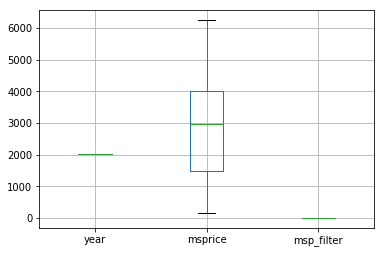

In [7]:
# Filtering out NaN values from the MSP Dataset.
msp.dropna(inplace=True)
msp.boxplot()
plt.show()

In [8]:
# To work with the textual data, I will reduce them all to lower case, and strip off any special characters at ends.

def clean_text(df, fields):
    """
    Takes a DataFrame as an input, and the corresponding
    fields that need to be cleaned. Checks whether the
    argument contains a list of fields or just a single one.
    """
    if isinstance(fields, (list,)):
        for field in fields:
            df[field] = df[field].map(lambda x: x.lower().strip())
        return df
    df[fields] = df[fields].map(lambda x: x.lower().strip())
    return df

In [9]:
# Using the IQR method, I will test for outliers and filter them.
# Note: Z-test can also be used, but the boxplot of the Monthly
# dataset revealed many outliers. So, I am using the IQR method.

def filter_outliers(df, fields):
    """
    Takes a DataFrame and the fields as inputs.
    Performs outlier filtering using IQR on the
    provided fields.
    """
    if isinstance(fields, (list,)):
        for field in fields:
            q1 = df[field].quantile(0.25)
            q3 = df[field].quantile(0.75)
            iqr = q3 - q1
            c = (df[field] > (q3 + 1.5*iqr)) | (df[field] < (q1 - 1.5*iqr))
            df = df[~c]
        return df
    q1 = df[fields].quantile(0.25)
    q3 = df[fields].quantile(0.75)
    iqr = q3 - q1
    c = (df[fields] > (q3 + 1.5*iqr)) | (df[fields] < (q1 - 1.5*iqr))
    df = df[~c]
    return df

In [10]:
# This is a commonly used method to test for stationarity by plotting
# the original time series, along with its rolling mean and rolling
# standard deviation. A confidence measure is also computed using the
# Dickey-Fuller Test.

def test_stationarity(series):
    """
    Takes a time series as an input, make sure that the index
    is a datetime object. Performs a basic test of stationarity,
    plots the results, and prints the output of Dickey-Fuller Test.
    """
    
    series.dropna(inplace=True)
    
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(window=12).std()

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(series, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [11]:
# Using the naive method seasonal_decompose from statsmodels.api,
# I will plot the time series and the respective graphs for the
# original data, the trend curve, the seasonality, and the residual
# data from the series.

def plot_trend(series):
    """
    Takes a time series as an argument, and performs naive seasonal
    decomposition on it. Ensure that the index of the series is a
    datetime object.
    """
    series = series.dropna()
    
    decomposition = seasonal_decompose(series, freq=12)    
    plt.figure(figsize=(15, 8))
    plt.subplot(411)
    plt.plot(series, label='Original')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Cleaning and saving the files

In [12]:
# Cleaning the text
msp = clean_text(msp, 'commodity')
monthly = clean_text(monthly, ['APMC', 'Commodity'])

# Filtering the outliers using IQR
monthly = filter_outliers(monthly, ['min_price', 'max_price', 'modal_price', 'arrivals_in_qtl'])

# Reset the index as datetime object
monthly.set_index('date', inplace=True)
monthly.index = pd.to_datetime(monthly.index)
monthly.sort_index(inplace=True)

if not os.path.exists('cleaned'):
    os.mkdir('cleaned')

msp.to_csv('cleaned/msp.csv')
monthly.to_csv('cleaned/monthly.csv')

## Loading the clean datasets

In [13]:
msp = pd.read_csv('cleaned/msp.csv', header=0, index_col=0)
monthly = pd.read_csv('cleaned/monthly.csv', header=0, index_col=0, parse_dates=['date'])

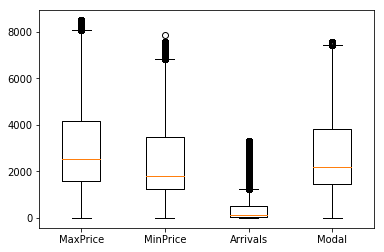

In [14]:
# Using boxplot on the clean dataset to see if the outliers have been filtered
plt.boxplot([monthly['max_price'],
             monthly['min_price'],
             monthly['arrivals_in_qtl'],
             monthly['modal_price']],
            labels=['MaxPrice', 'MinPrice', 'Arrivals', 'Modal'])
plt.show()

## Testing stationarity

In [15]:
# Here, I will use the ACF and stem plot to observe how
# the average prices and autocorrelation of APMC/Commodity
# clusters vary. I have limited the analysis to top 10
# clusters with more than 25 data points.

def check_autocorr(df, fields, count=10):
    """
    Takes DataFrame and grouping fields as inputs, and
    outputs stem plots for the groups and ACF plots to
    check for autocorrelation. Count can be used to limit
    the number of plots.
    """
    i = 0
    for name, group in df.groupby(fields):
        if group.shape[0] > 25 and i < count:
            # Since the data had values for same month and year, I
            # have resampled it month-wise, taking the mean of the
            # values. I did this because there was no way to tell
            # which values were redundant.
            series = group['modal_price']
            series = series.resample('M').mean().map(lambda x: float(x)).dropna(inplace=False)
            
            fig, ax = plt.subplots(figsize=(12, 5))
            ax.plot(series)
            ax.set(xlabel='Date', ylabel='Price',
                   title=name)
            plt.tight_layout()
            plt.show()
            plot_acf(series)
            plt.show()
            if series.autocorr() > 0.8:
                plot_trend(series)
            i += 1

_Reason behind plotting the ACF graphs is to see whether that particular timeseries is exhibiting autocorrelation. If it is, then I will plot the seasonality and trend curve, because that implies seasonality in the APMC/Commodity cluster._

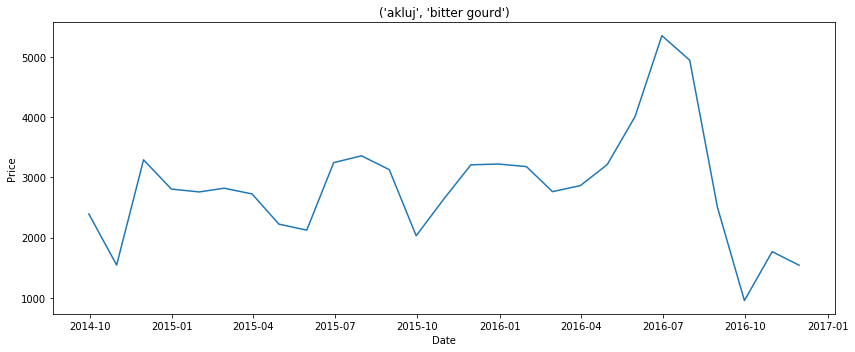

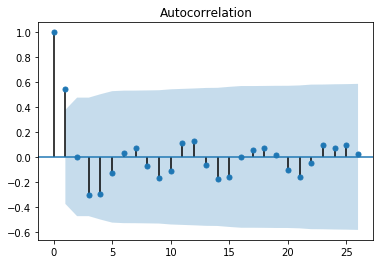

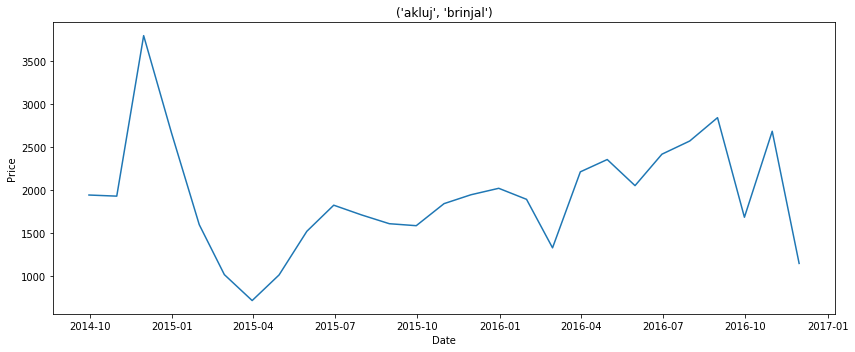

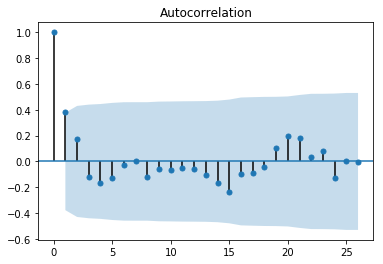

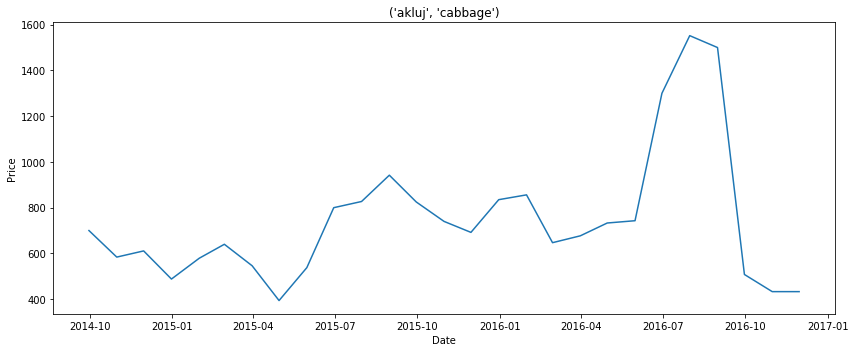

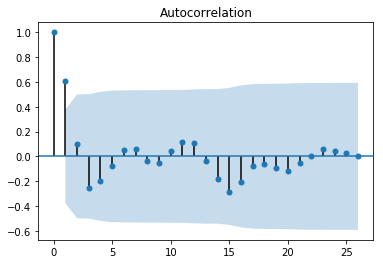

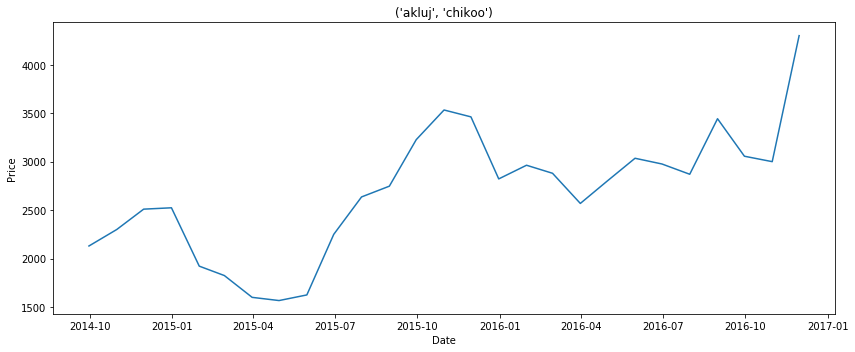

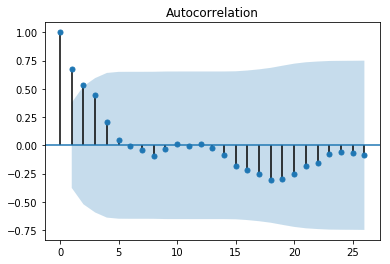

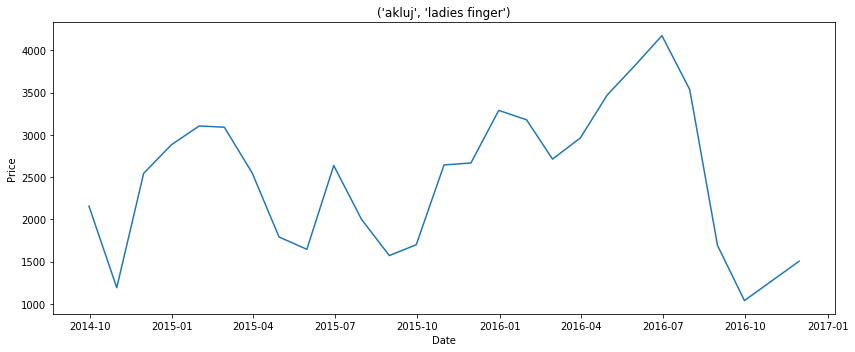

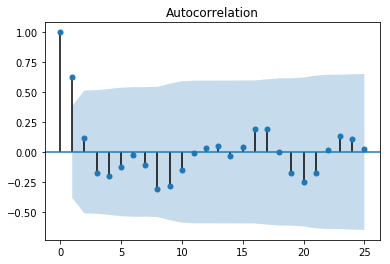

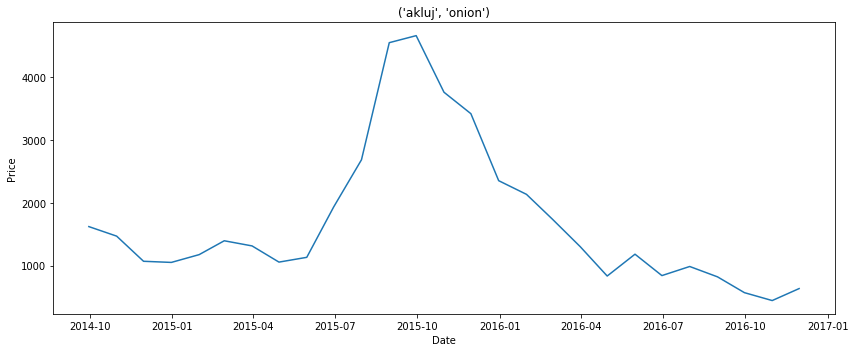

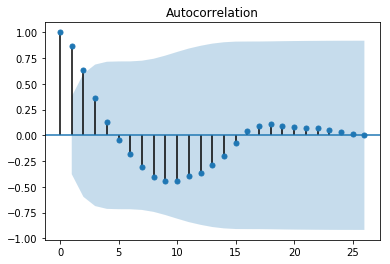

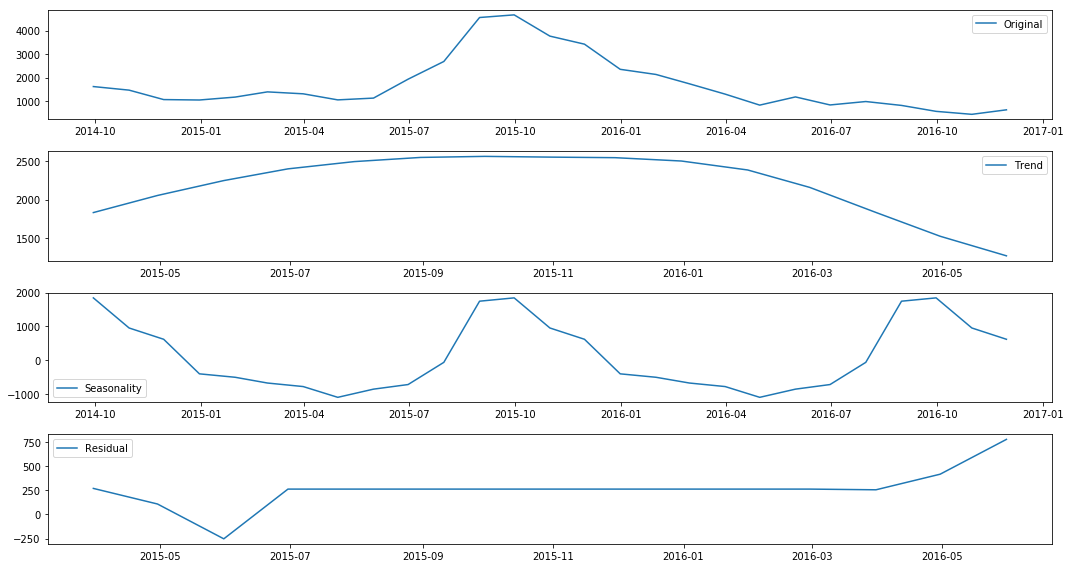

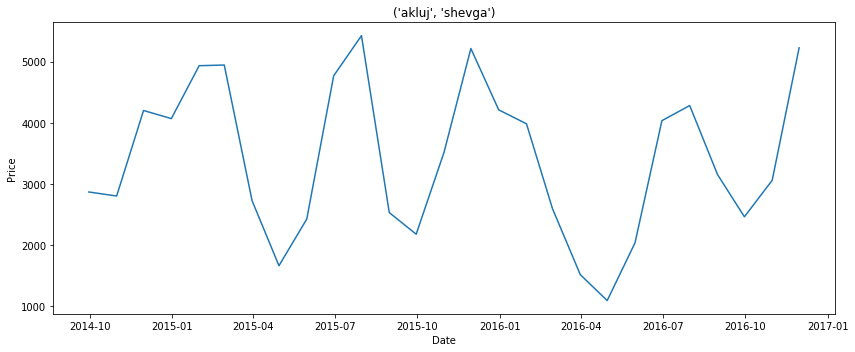

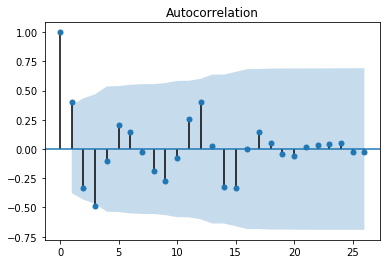

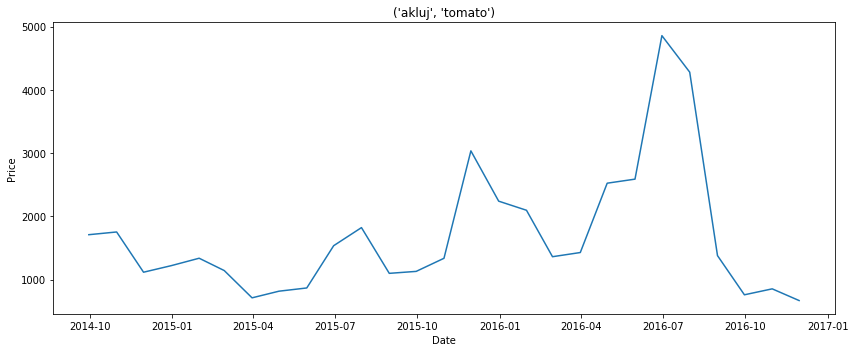

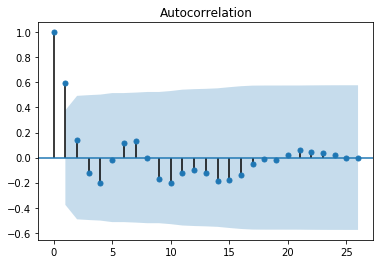

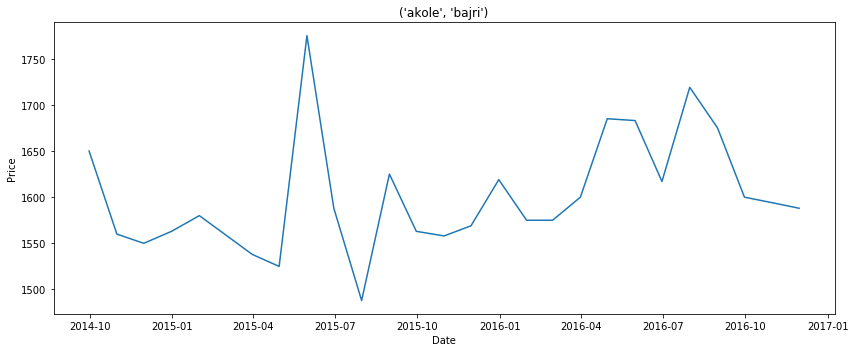

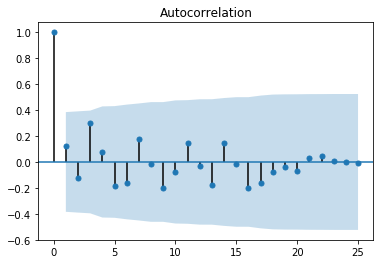

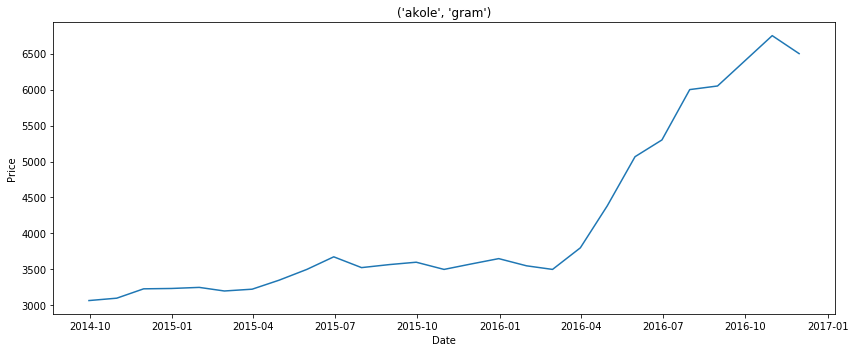

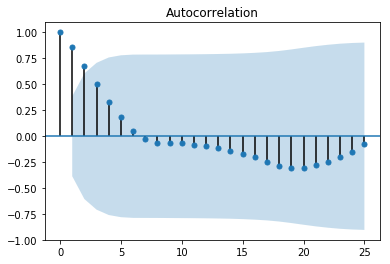

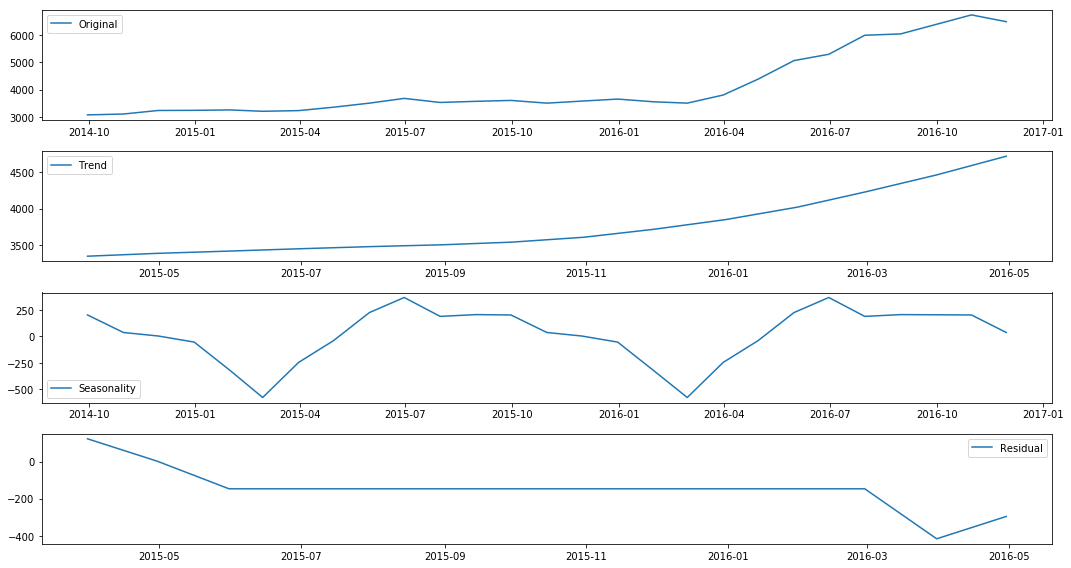

In [16]:
check_autocorr(monthly, ['APMC', 'Commodity'])

## Comparing MSP with Monthly data

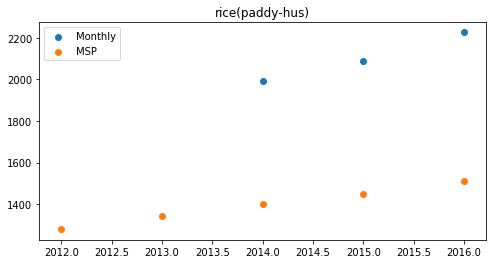

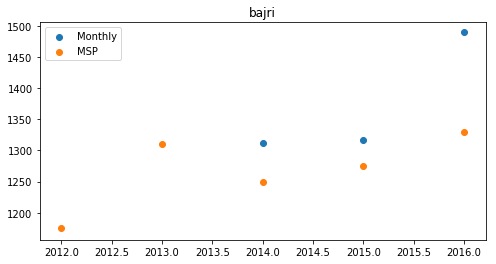

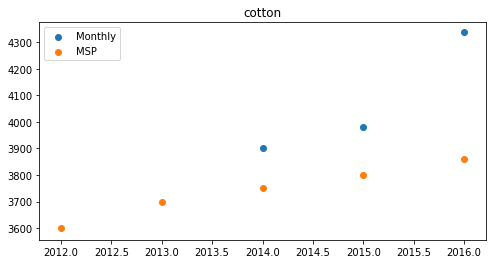

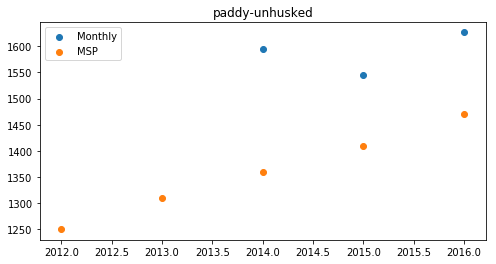

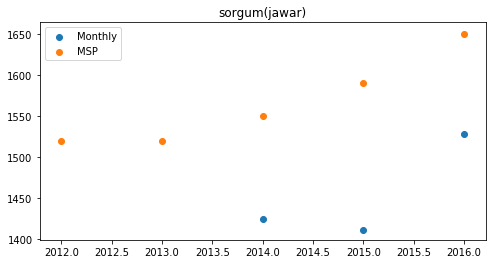

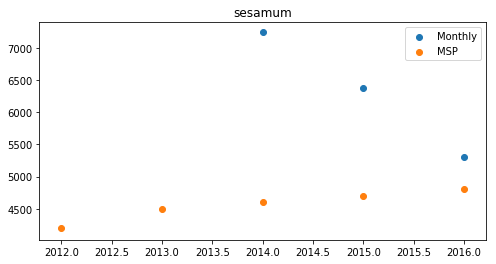

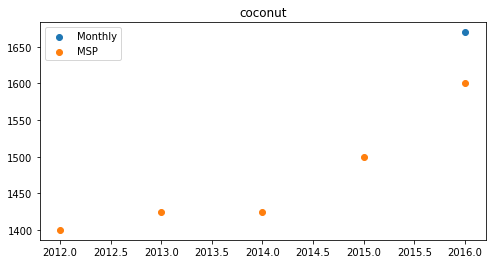

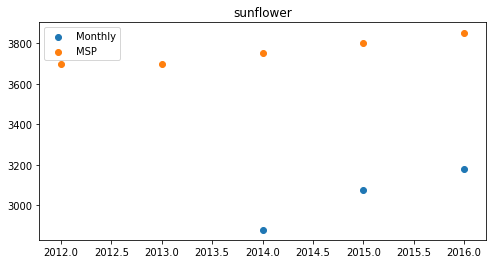

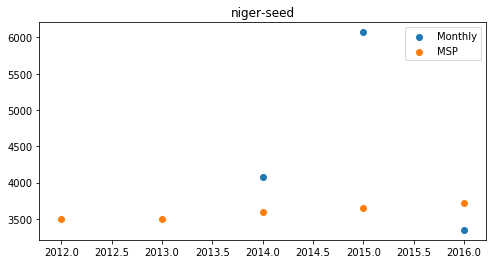

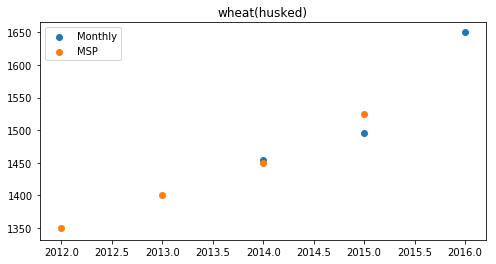

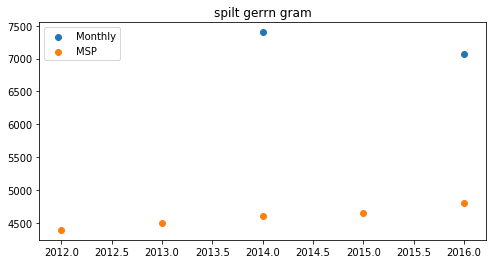

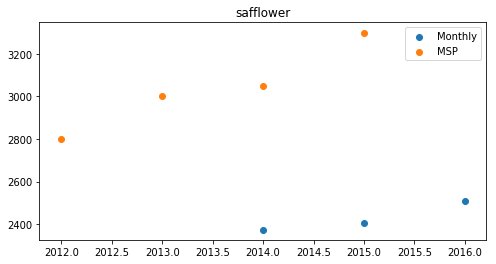

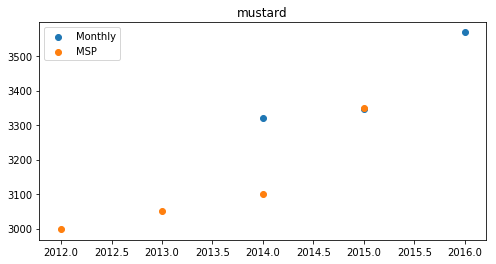

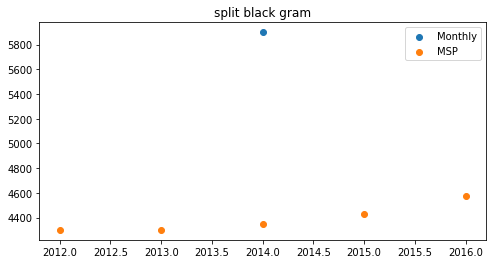

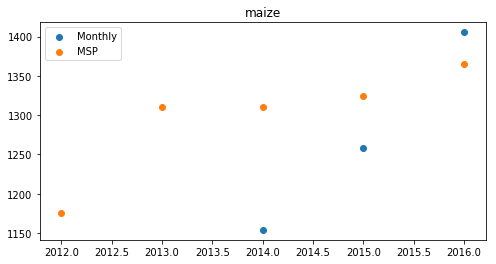

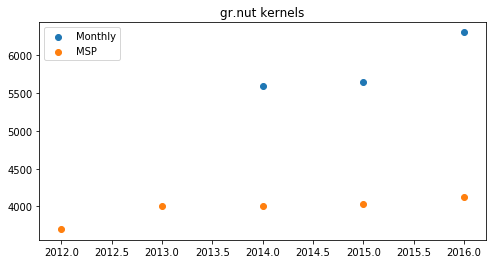

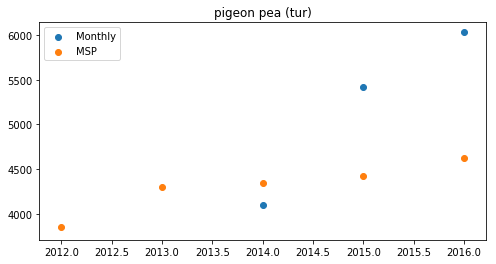

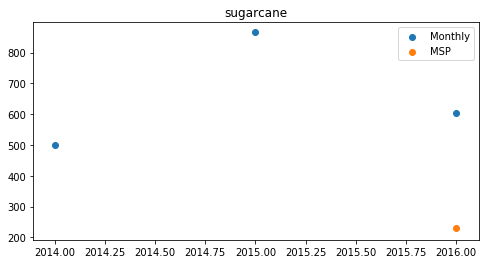

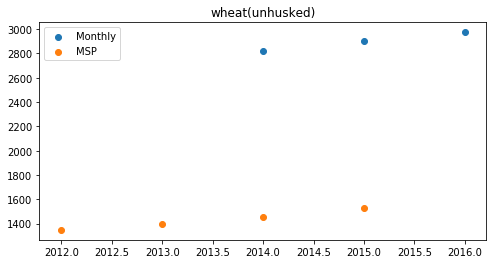

In [17]:
# Simple comparison of the commodity prices for all the commodities present in both the datasets.

common = list(set(list(monthly['Commodity'])).intersection(list(msp['commodity'])))
for crop in common:
    monthly_series = monthly[monthly['Commodity'] == crop]['min_price'].resample('Y').mean()
    monthly_series = monthly_series.map(lambda x: float(x)).dropna(inplace=False)
    msp_series = msp[msp['commodity'] == crop]
    plt.figure(figsize=(8, 4))
    plt.scatter(monthly_series.index.year, monthly_series.values, label='Monthly')
    plt.scatter(msp_series.year, msp_series.msprice, label='MSP')
    plt.legend()
    plt.title(crop)
    plt.show()